In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tce_file = "BLS_injection_results.txt" # These are the BLS returned "TCEs" from the 20k injected transits, (does linear mean they placed period and depths evenly across some grid?)
columns = ["pass","win","type","injnum","period","tzero","power","dur","depth","snr","deptest1","deptest2",
           "stmass","stradius","chisq",
           "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3","mindBIC",
           "nloops","npoints",
           "nintransit","26","27","28","29","30","31",
           "Tmag","Teff","logg","injrec","trprob"]

tces = pd.read_csv(tce_file, names=columns)


### Split data into a training and test set:
Split up the data into a training set which the model will learn on and a test set that we apply the model to in order to see how well it performs. In general training should be larger than test.


Using the default parameters, sklearn.model_selection.train_test_split() splits into 75%, 25% training and test

https://www.geeksforgeeks.org/how-to-split-the-dataset-with-scikit-learns-train_test_split-function/

In [3]:
# Kelsey and Jason only trained their classifiers on a subset of the columns, so let's reduce to only those for simplicity:
metrics=["power","dur","depth","snr","chisq","bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3","mindBIC","nloops"]

features = np.array(tces[metrics]) # Array of features that Kelsey and Jason used to describe a "tce"

labels = np.array(tces['injrec']) # The recovery value for each, 0 if unrecovered, 1 if recovered. What does recovered here mean? That the BLS result closely matched the injected transit?  

labels_train, labels_test, features_train, features_test = train_test_split(labels, features, test_size=0.25)

print(f'We have {len(labels_train)} training "tces", and {len(labels_test)} testing "tces"') 
print(f"That's {(100*len(labels_train))/(len(labels_test)+len(labels_train))}% of the whole dataset designated to training")

We have 172792 training "tces", and 57598 testing "tces"
That's 74.99978297669169% of the whole dataset designated to training


### Train a random forest classifier:
Now the magic: sklearn.ensemble.RandomForestClassifier

https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/

From what I understand, a bunch of decision trees are made where each a number of starting nodes are chosen from a random subset of the training data.
Each tree also only uses a random subset of the features available. 

At each split in the tree the algorithm choses the best feature based on some criterion (default is optimizing Gini impurity). The splits keep going down until a defined stopping point is met
(default is until all leaves are pure or have less options than the minimum you told it to be able to split on).

The output from each tree ?
The final output is the most common class from all the trees


<div>
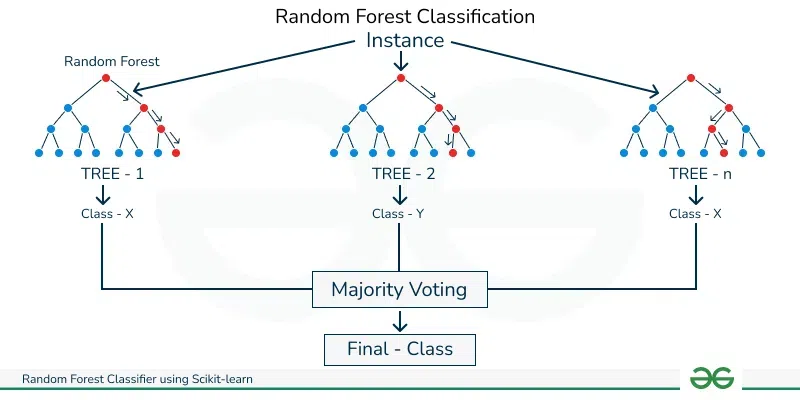
</div>


In [4]:
# Train a model
rf = RandomForestClassifier(random_state=0) # initialize a random forest
rf.fit(features_train, labels_train)


# My notes: This seems sensitive to what features you're throwing at it. The classifier will do better if only the more important features are supplied to it?
# I think a good test would be then to see what the feature scores are, then train it again with only those

# My questions: 
# How does each tree choose the split path it contributes to the end vote?
# Would you not always do better having more trees (n_estimators)


RandomForestClassifier(random_state=0)

### Estimator performance via cross validation
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

There is a worry that if you keep tweaking the hyperparameters of the model until you get a classify your test set extremely well there can be some amount of overfitting since you know things about your test set!
This would lead to your model still not performing well on unseen generalized data. We can use a validation set which can be used to tune the hyper parameters after training, and then we can do our final predictions on the test set.

That's great, but we've then split our data into 3 parts, so we don't have as much to train or test on. Plus the performance depends on the random selection of the training, validation, and test sets.

When doing cross validation you no longer need the validation set. The training set is divied up into K "folds". For each fold that exists the model is trained on the rest of the training data, then validated on that remaining fold.

<div>
<img src="attachment:0f2abdf3-ef06-4aa5-b016-8e8bf659f44c.png" width="500"/>
</div>



### Predictions and confusion matrices:

Now that we have a classifier trained we can use it to predict whether or not the BLS returned "TCEs" in the test set should be classified as recovered or not. The confusion matrix is a good tool for this, as it shows the rate and numbers of:

* True Positive (TP): The model correctly predicted a positive outcome (the actual outcome was positive).
* True Negative (TN): The model correctly predicted a negative outcome (the actual outcome was negative).
* False Positive (FP): The model incorrectly predicted a positive outcome (the actual outcome was negative). Also known as a Type I error.
* False Negative (FN): The model incorrectly predicted a negative outcome (the actual outcome was positive). Also known as a Type II error.

What did Susan mean by "completeness"? This seems higher than 82%

In [5]:
scores = cross_val_score(rf, features_train, labels_train, cv=5)
print(f'Scores per model run: {scores}')
print(f'mean: {scores.mean()} with a std of {scores.std()}')


Scores per model run: [0.98822304 0.98862814 0.98938017 0.9879912  0.98891718]
mean: 0.9886279480804326 with a std of 0.0004937395580127753


Accuracy: 0.9894267162054238


Text(0.5, 1.0, 'from estimator')

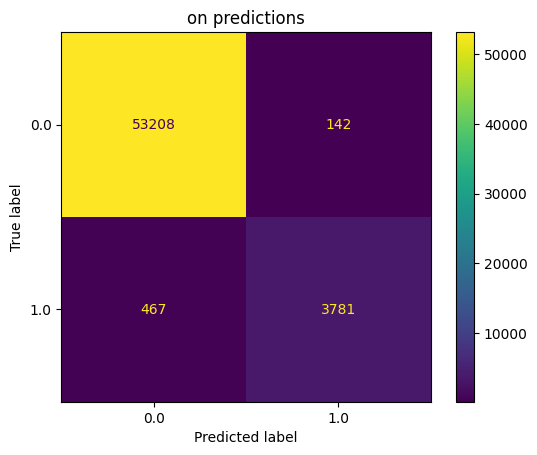

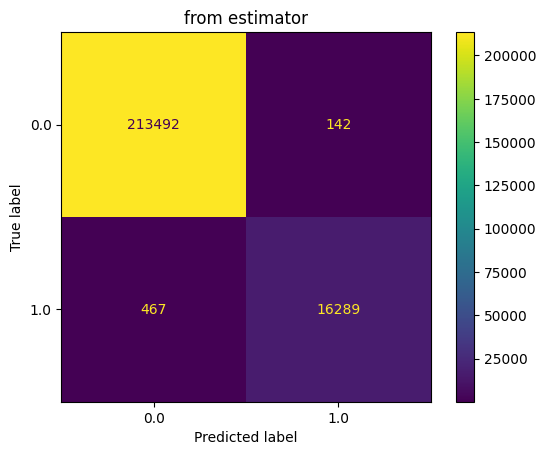

In [23]:
# Make some predictions on the test set:
labels_pred = rf.predict(features_test)
accuracy = accuracy_score(labels_test, labels_pred) # This literally returns the percentage the classifier got right (1 - (np.count_nonzero(np.where(labels_test!=labels_pred)))/len(labels_test))
print("Accuracy:", accuracy)

#cm = confusion_matrix(y_pred=labels_pred, y_true=labels_test) 

_ = ConfusionMatrixDisplay.from_predictions(labels_test, labels_pred, normalize=None)
plt.title('on predictions')

_ = ConfusionMatrixDisplay.from_estimator(rf, features, labels, normalize=None) # I don't super trust this one since it's on everything?
plt.title('from estimator')



### Which datasets are we failing on? Is there an injected transit period/duration combo that we suck at correctly identifying as real?

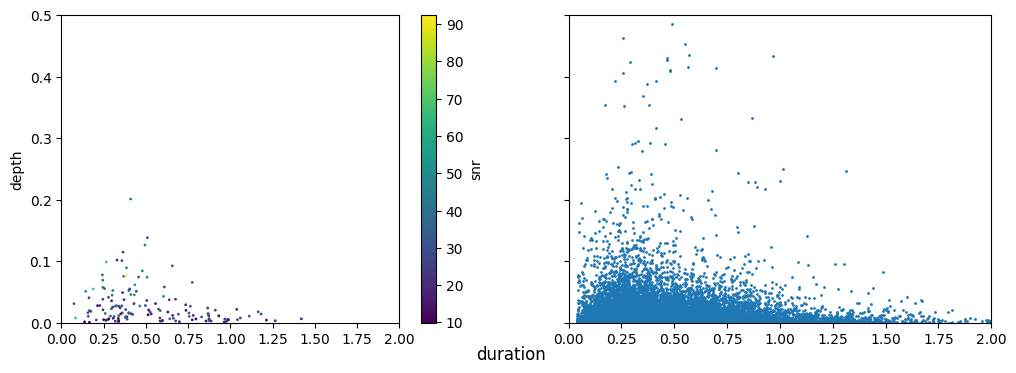

In [57]:
# False positives (classifier said BLS result was good when it wasn't) We have less of these

# Is it better to run the classifier on the whole thing and look where that fails or should I only use it on the test set like I'm doing here?
test_df = pd.DataFrame(features_test, columns=metrics)
test_df['actual_val']=labels_test
test_df['predicted_val']=labels_pred

false_positives = test_df[(test_df["actual_val"] == 0) & (test_df["predicted_val"] == 1)]
#false_positives

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharex=True, sharey=True)
im = ax1.scatter(false_positives['dur'], false_positives['depth'], c=false_positives['snr'], s=1)
ax2.scatter(test_df['dur'], test_df['depth'], s=1)
fig.colorbar(im, label='snr')
fig.supxlabel('duration')
ax1.set_ylabel('depth')
ax1.set_ylim(0,0.5)
ax1.set_xlim(0,2)
plt.show()

# Looks like there's an over density of low depths across the gambit of duration?

# False negatives (classifier said BLS result was bad when it really was close to the injected transit) We have more of these


### Fine tuning this classifier
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

### The apparently most common algorithms for this type of problem: Random Forest Classifier, K – Nearest Neighbors, Support Vector Machine
